In [1]:
import ot
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from scipy.stats import norm
from scipy.spatial.distance import cdist
import math

import sys
DATA_PATH = '/home/risitop/OneDrive/Documents/PHD/y1/data/'
sys.path.append(DATA_PATH)

plt.style.use('dark_background')

In [2]:
def load_scores(fname, comps):
    X = []
    with open(fname, 'r') as f:
        for line in f:
            line = line[:-1].split(',')
            if line[0] in comps:
                X.append(list(map(float, line[1:])))
    return np.array(X).T

In [3]:
files = ['184', '352', '471', '856', '857', '861', '1057', '1058', 'CHLA9', 'CHLA10', 'D085T8', 'TC71', 'Y79']
Xs = {}
for f in files:
    Xs[f] = load_scores(DATA_PATH + 'scores/%s.csv' % f, ['IC1+', 'IC2+'])
    print(f, Xs[f].shape)
    
banlist = ['184', 'Y79', '857', '1057']

184 (187, 2)
352 (1937, 2)
471 (483, 2)
856 (398, 2)
857 (149, 2)
861 (906, 2)
1057 (128, 2)
1058 (478, 2)
CHLA9 (3752, 2)
CHLA10 (3407, 2)
D085T8 (183, 2)
TC71 (1478, 2)
Y79 (2874, 2)


In [4]:
xs = Xs['D085T8']
yt = Xs['CHLA10']

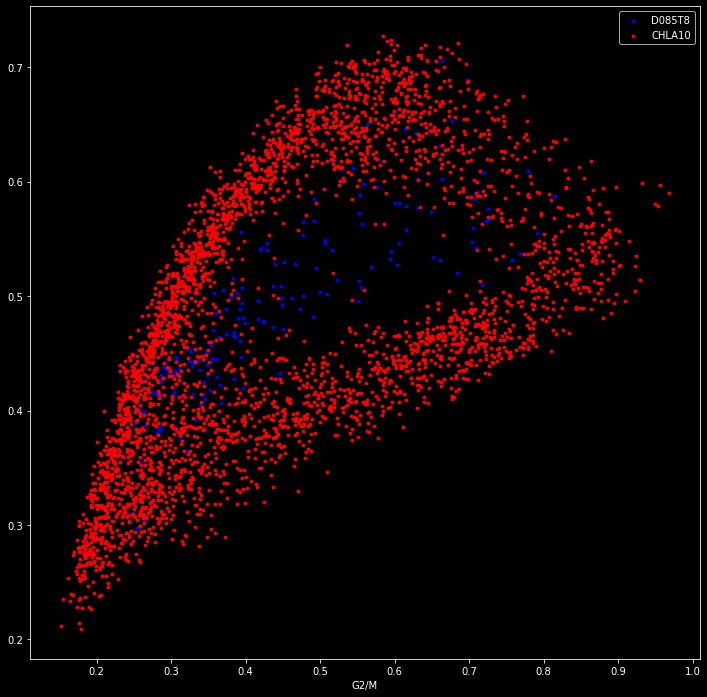

In [229]:
plt.figure(figsize=(12,12))

plt.scatter(xs[:,0], xs[:,1], s=8, c='blue', label='D085T8')
plt.scatter(yt[:,0], yt[:,1], s=8, c='red', label='CHLA10')
plt.xlabel('G1/S')
plt.xlabel('G2/M')
plt.legend()

plt.savefig("before_OT.png")
pass

In [230]:
w_x, w_y = np.ones((len(xs),))/len(xs), np.ones((len(yt),))/len(yt)
M = ot.dist(xs, yt)
M /= M.max()

Gs = ot.sinkhorn(w_x, w_y, M, 1e-3)
xt_nodens = np.dot(Gs, yt)*len(xs)

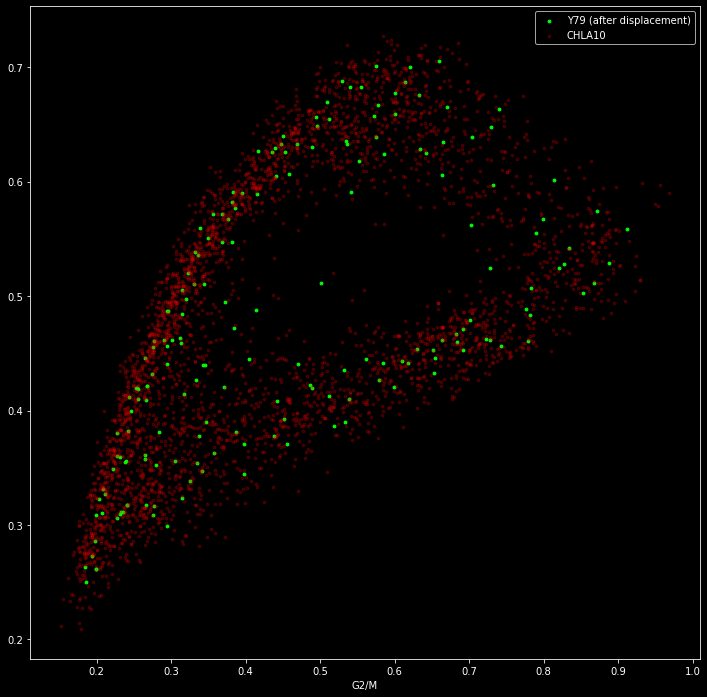

In [232]:
plt.figure(figsize=(12,12))

plt.scatter(xt_nodens[:,0], xt_nodens[:,1], s=8, c='lime', label='Y79 (after displacement)')
plt.scatter(yt[:,0], yt[:,1], s=8, alpha=0.2, c='red', label='CHLA10')
plt.xlabel('G1/S')
plt.xlabel('G2/M')
plt.legend()

plt.savefig("after_OT.png")
pass

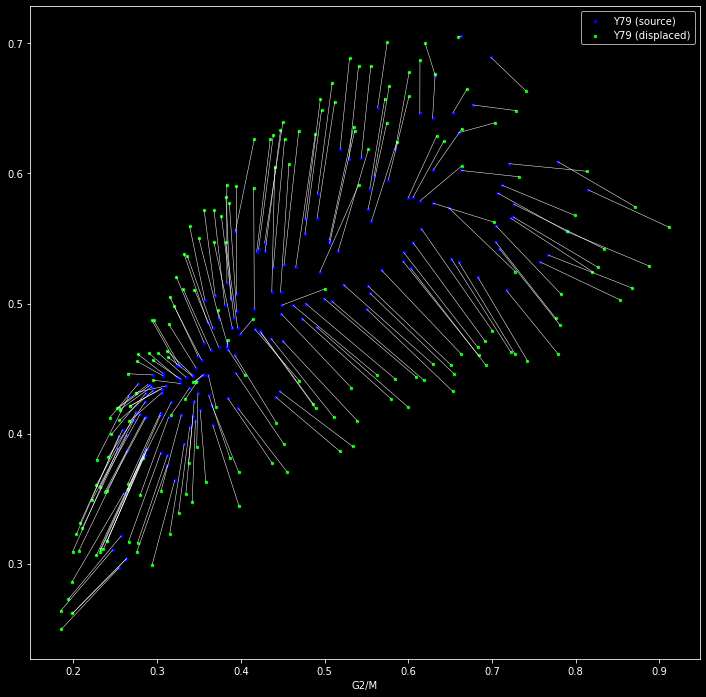

In [233]:
plt.figure(figsize=(12,12))
for ((x1, y1), (x2, y2)) in zip(xs, xt_nodens):
    plt.plot([x1, x2], [y1, y2], c='w', linewidth=0.5)
plt.scatter(xs[:,0], xs[:,1], s=6, c='blue', label='Y79 (source)')
plt.scatter(xt_nodens[:,0], xt_nodens[:,1], s=6, c='lime', label='Y79 (displaced)')
plt.xlabel('G1/S')
plt.xlabel('G2/M')
plt.legend()

plt.savefig("OT_displacement.png")

# Local density computation

In [218]:
def adjust_densities(X, sigma=1):
    
    n = len(X)
    K_np = norm.pdf(cdist(X, X), scale=sigma)
    
    # Cost matrix
    K_np = comp_K(X, sigma)
    M_np = K_np.mean(axis=1)
    KM_np = K_np - M_np
    P_np = np.dot(KM_np.T, KM_np)
    n = len(P_np)
    P = matrix(P_np, (n,n))
    p = matrix( [1.0/n]*n, (n,1)) # alpha vector
    
    # Inequality constraints
    G = matrix(
        np.vstack( (np.diag([-1.0]*n), KM_np) ),
        (2*n,n)
    )
    h = matrix([0.0]*n + [1/(n*math.sqrt(2*math.pi))]*n, (2*n,1))
    
    # Equality constraints
    A = matrix([1.0]*n, (1,n))
    b = matrix(1.0, (1,1))
    
    sol = solvers.qp(P, p, G, h, A, b)
    return sol['x']

In [226]:
s = 0.001
alphas = adjust_densities(yt, sigma=s)
K_np = comp_K(yt, s)

     pcost       dcost       gap    pres   dres
 0:  2.9382e-04 -1.3993e+00  7e+03  8e+01  6e+01
 1:  2.9383e-04 -1.3986e+00  7e+01  9e-01  6e-01
 2:  2.9383e-04 -1.3400e+00  7e+00  7e-02  5e-02
 3:  2.9397e-04 -1.3789e+00  6e+00  6e-02  4e-02
 4:  5.0746e-04 -1.4484e+00  6e+00  5e-02  4e-02
 5:  4.6859e-04 -1.4472e+00  6e+00  5e-02  3e-02
 6:  4.0996e-04 -1.4824e+00  5e+00  4e-02  3e-02
 7:  5.2602e-04 -1.4978e+00  4e+00  3e-02  2e-02
 8:  5.2741e-04 -1.5073e+00  4e+00  3e-02  2e-02
 9:  5.3151e-04 -1.4681e+00  4e+00  3e-02  2e-02
10:  5.4320e-04 -1.3996e+00  4e+00  3e-02  2e-02
11:  6.2117e-04 -1.4812e+00  4e+00  3e-02  2e-02
12:  9.4363e-04 -1.4099e+00  4e+00  2e-02  1e-02
13:  1.5435e-03 -1.3685e+00  3e+00  1e-02  9e-03
14:  1.7598e-03 -1.2211e+00  2e+00  9e-03  6e-03
15:  1.7599e-03 -1.1815e+00  2e+00  9e-03  6e-03
16:  1.7619e-03 -1.2172e+00  2e+00  9e-03  6e-03
17:  1.7740e-03 -1.1752e+00  2e+00  9e-03  6e-03
18:  1.8644e-03 -1.1359e+00  2e+00  8e-03  5e-03
19:  1.8747e-03 -1.14

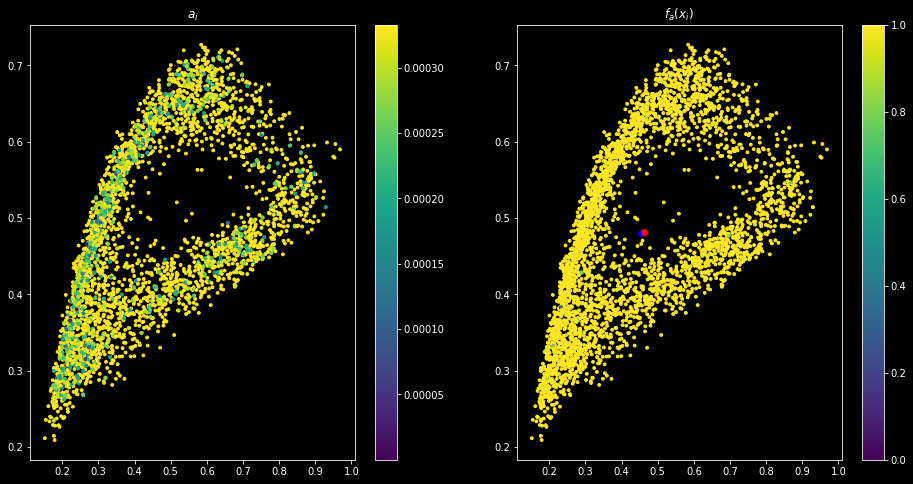

In [227]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(yt[:,0], yt[:,1], s=8, c=alphas, label='CHLA10')
plt.colorbar()
plt.title('$a_i$')

plt.subplot(1,2,2)
plt.scatter(yt[:,0], yt[:,1], s=8, c=np.dot(K_np, alphas), label='CHLA10')
plt.scatter(yt[:,0].mean(), yt[:,1].mean(), c='b')
plt.scatter(np.dot(yt[:,0], alphas), np.dot(yt[:,1], alphas), c='r')
plt.colorbar()
plt.title('$f_a(x_i)$')

plt.savefig('figures/KDE_uniformization_CHLA10.png')

In [238]:
np.array(alphas)

array([[0.00033127],
       [0.00014181],
       [0.00033271],
       ...,
       [0.00024705],
       [0.00033271],
       [0.000243  ]])

In [249]:
def get_weights(X, bet=1):
    w = (ot.dist(X, X).sum(axis=0))**bet
    w /= w.sum()
    return w
    
def OT_transform(Xs, Yt):
    w_x, w_y = np.array(adjust_densities(Xs, 0.003)), np.array(adjust_densities(Yt, 0.001))
    w_x, w_y = w_x.reshape(len(w_x),), w_y.reshape(len(w_y),)
    M = ot.dist(Xs, Yt)
    M /= M.max()

    Gs = ot.sinkhorn(w_x, w_y, M, 1e-3)
    print(Xs.shape)
    print(Yt.shape)
    print(w_x.shape)
    print(w_y.shape)
    print(M.shape)
    print(Gs.shape)
    return np.dot(np.diag(1/w_x), np.dot(Gs, Yt))

In [250]:
xt = OT_transform(xs, yt)

     pcost       dcost       gap    pres   dres
 0:  5.4645e-03 -1.3956e+00  4e+02  2e+01  1e+01
 1:  5.4646e-03 -1.3824e+00  6e+00  2e-01  2e-01
 2:  5.4647e-03 -8.7502e-01  1e+00  4e-02  3e-02
 3:  5.4841e-03 -8.3707e-01  1e+00  4e-02  3e-02
 4:  6.3723e-03 -7.8716e-01  1e+00  3e-02  2e-02
 5:  6.0241e-03 -6.6887e-01  9e-01  2e-02  1e-02
 6:  6.1509e-03 -6.9715e-01  9e-01  2e-02  1e-02
 7:  6.2456e-03 -6.6009e-01  9e-01  2e-02  1e-02
 8:  8.7457e-03 -4.2568e-01  5e-01  6e-03  5e-03
 9:  8.6157e-03 -3.2846e-01  4e-01  4e-03  3e-03
10:  8.9645e-03 -9.8318e-02  1e-01  9e-04  6e-04
11:  8.7305e-03 -1.9243e-02  3e-02  1e-04  7e-05
12:  8.4107e-03  1.3636e-03  7e-03  7e-07  5e-07
13:  8.3388e-03  6.7238e-03  2e-03  6e-15  2e-12
14:  8.3159e-03  8.2605e-03  6e-05  4e-15  9e-13
15:  8.3124e-03  8.3086e-03  4e-06  6e-15  1e-11
16:  8.3120e-03  8.3116e-03  5e-07  5e-15  9e-10
17:  8.3120e-03  8.3120e-03  5e-08  2e-15  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dre

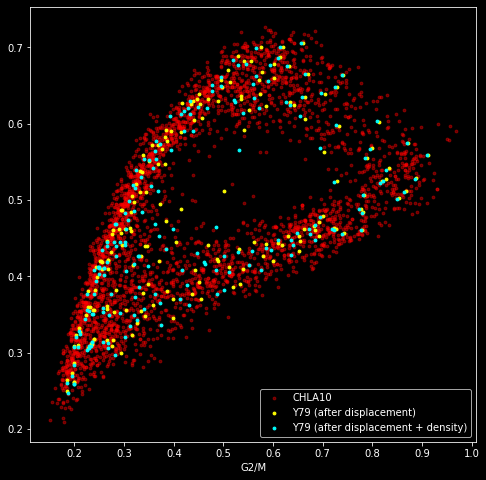

In [252]:
plt.figure(figsize=(8,8))

plt.scatter(yt[:,0], yt[:,1], s=8, alpha=0.4, c='red', label='CHLA10')
plt.scatter(xt_nodens[:,0], xt_nodens[:,1], s=8, c='yellow', label='Y79 (after displacement)')
plt.scatter(xt[:,0], xt[:,1], s=8, c='cyan', label='Y79 (after displacement + density)')
plt.xlabel('G1/S')
plt.xlabel('G2/M')
plt.legend()

plt.savefig("after_OT.png")
pass

In [42]:
np.min(a)

0.00019050254444316468